### Loading Dataset and Libraries

In [1]:
import pandas as pd
import numpy as np

import patsy
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV,  ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline
%config InlineBackend.figure_formats = ['retina']

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('apt_info.csv',sep='\t', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            1597 non-null   int64 
 1   address               1597 non-null   object
 2   price                 1597 non-null   object
 3   num_beds              1597 non-null   object
 4   num_baths             1597 non-null   object
 5   sq_ft                 1597 non-null   object
 6   listed_date           1597 non-null   object
 7   neighborhood          1597 non-null   object
 8   fee                   1597 non-null   object
 9   built_yr              1597 non-null   object
 10  unit                  1597 non-null   object
 11  floors                1597 non-null   object
 12  num_amenities         1597 non-null   int64 
 13  closest_dist_station  1597 non-null   object
 14  url                   1597 non-null   object
dtypes: int64(2), object(13)
memory usage: 

In [3]:
df.head()

,Unnamed: 0,address,price,num_beds,num_baths,sq_ft,listed_date,neighborhood,fee,built_yr,unit,floors,num_amenities,closest_dist_station,url
0,0,The Aldyn,missing,2,2,missing,missing,missing,missing,missing,missing,missing,2,missing,https://www.cityrealty.com/nyc/riverside-dr-we...
1,1,The Santa Rosa,3750,1,1,missing,"Sep 2, 2021",Carnegie Hill,Rental,1910,53,6,1,0.15,https://www.cityrealty.com/nyc/carnegie-hill/t...
2,2,501 West 167th Street,3000,4,1,missing,"Sep 2, 2021",Washington Heights,No Fee Rental,1907,17,5,1,0.13,https://www.cityrealty.com/nyc/washington-heig...
3,3,1253 Saint Nicholas Avenue,2500,3,1,missing,"Sep 2, 2021",Washington Heights,No Fee Rental,1910,32,6,1,0.24,https://www.cityrealty.com/nyc/washington-heig...
4,4,206 Audubon Avenue,1900,2,1,\n,"Sep 2, 2021",Washington Heights,No Fee Rental,1914,35,6,1,0.28,https://www.cityrealty.com/nyc/washington-heig...


### Data Cleaning and Exploratory Data Analysis

-  Target: Rental Price

- Feature candidates:
    1. num_baths: number of bathroom
    2. sq_ft: squarefeet
    3. built_yr: year of apartment building built
    4. location, i.e., neighborhood
    6. units available in building
    7. floor of apartment located
    8. number of amenities available
    9. distance to the closest station
    10. bedrooms
   
***Notes***: the webpage counted more than 6 bedrooms as 6 

In [4]:
df.replace({',':'', '\n': np.NaN, 'missing': np.NaN}, inplace = True, regex = True)

In [5]:
df = df.drop(columns = ['Unnamed: 0']) # drop unnamed:0 columns 
data_type = {'price': float,
            'num_baths': float,
            'sq_ft': float,
            'built_yr': float,
            'unit': float,
            'floors': float,
            'num_amenities': float,
            'closest_dist_station': float}

df = df.astype(data_type)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   address               1597 non-null   object 
 1   price                 1569 non-null   float64
 2   num_beds              1597 non-null   object 
 3   num_baths             1593 non-null   float64
 4   sq_ft                 588 non-null    float64
 5   listed_date           1569 non-null   object 
 6   neighborhood          1569 non-null   object 
 7   fee                   1495 non-null   object 
 8   built_yr              1482 non-null   float64
 9   unit                  1485 non-null   float64
 10  floors                1491 non-null   float64
 11  num_amenities         1597 non-null   float64
 12  closest_dist_station  1454 non-null   float64
 13  url                   1597 non-null   object 
dtypes: float64(8), object(6)
memory usage: 174.8+ KB


In [6]:
df.dropna(axis = 0, inplace = True)
df.reset_index(drop = True, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   address               522 non-null    object 
 1   price                 522 non-null    float64
 2   num_beds              522 non-null    object 
 3   num_baths             522 non-null    float64
 4   sq_ft                 522 non-null    float64
 5   listed_date           522 non-null    object 
 6   neighborhood          522 non-null    object 
 7   fee                   522 non-null    object 
 8   built_yr              522 non-null    float64
 9   unit                  522 non-null    float64
 10  floors                522 non-null    float64
 11  num_amenities         522 non-null    float64
 12  closest_dist_station  522 non-null    float64
 13  url                   522 non-null    object 
dtypes: float64(8), object(6)
memory usage: 57.2+ KB


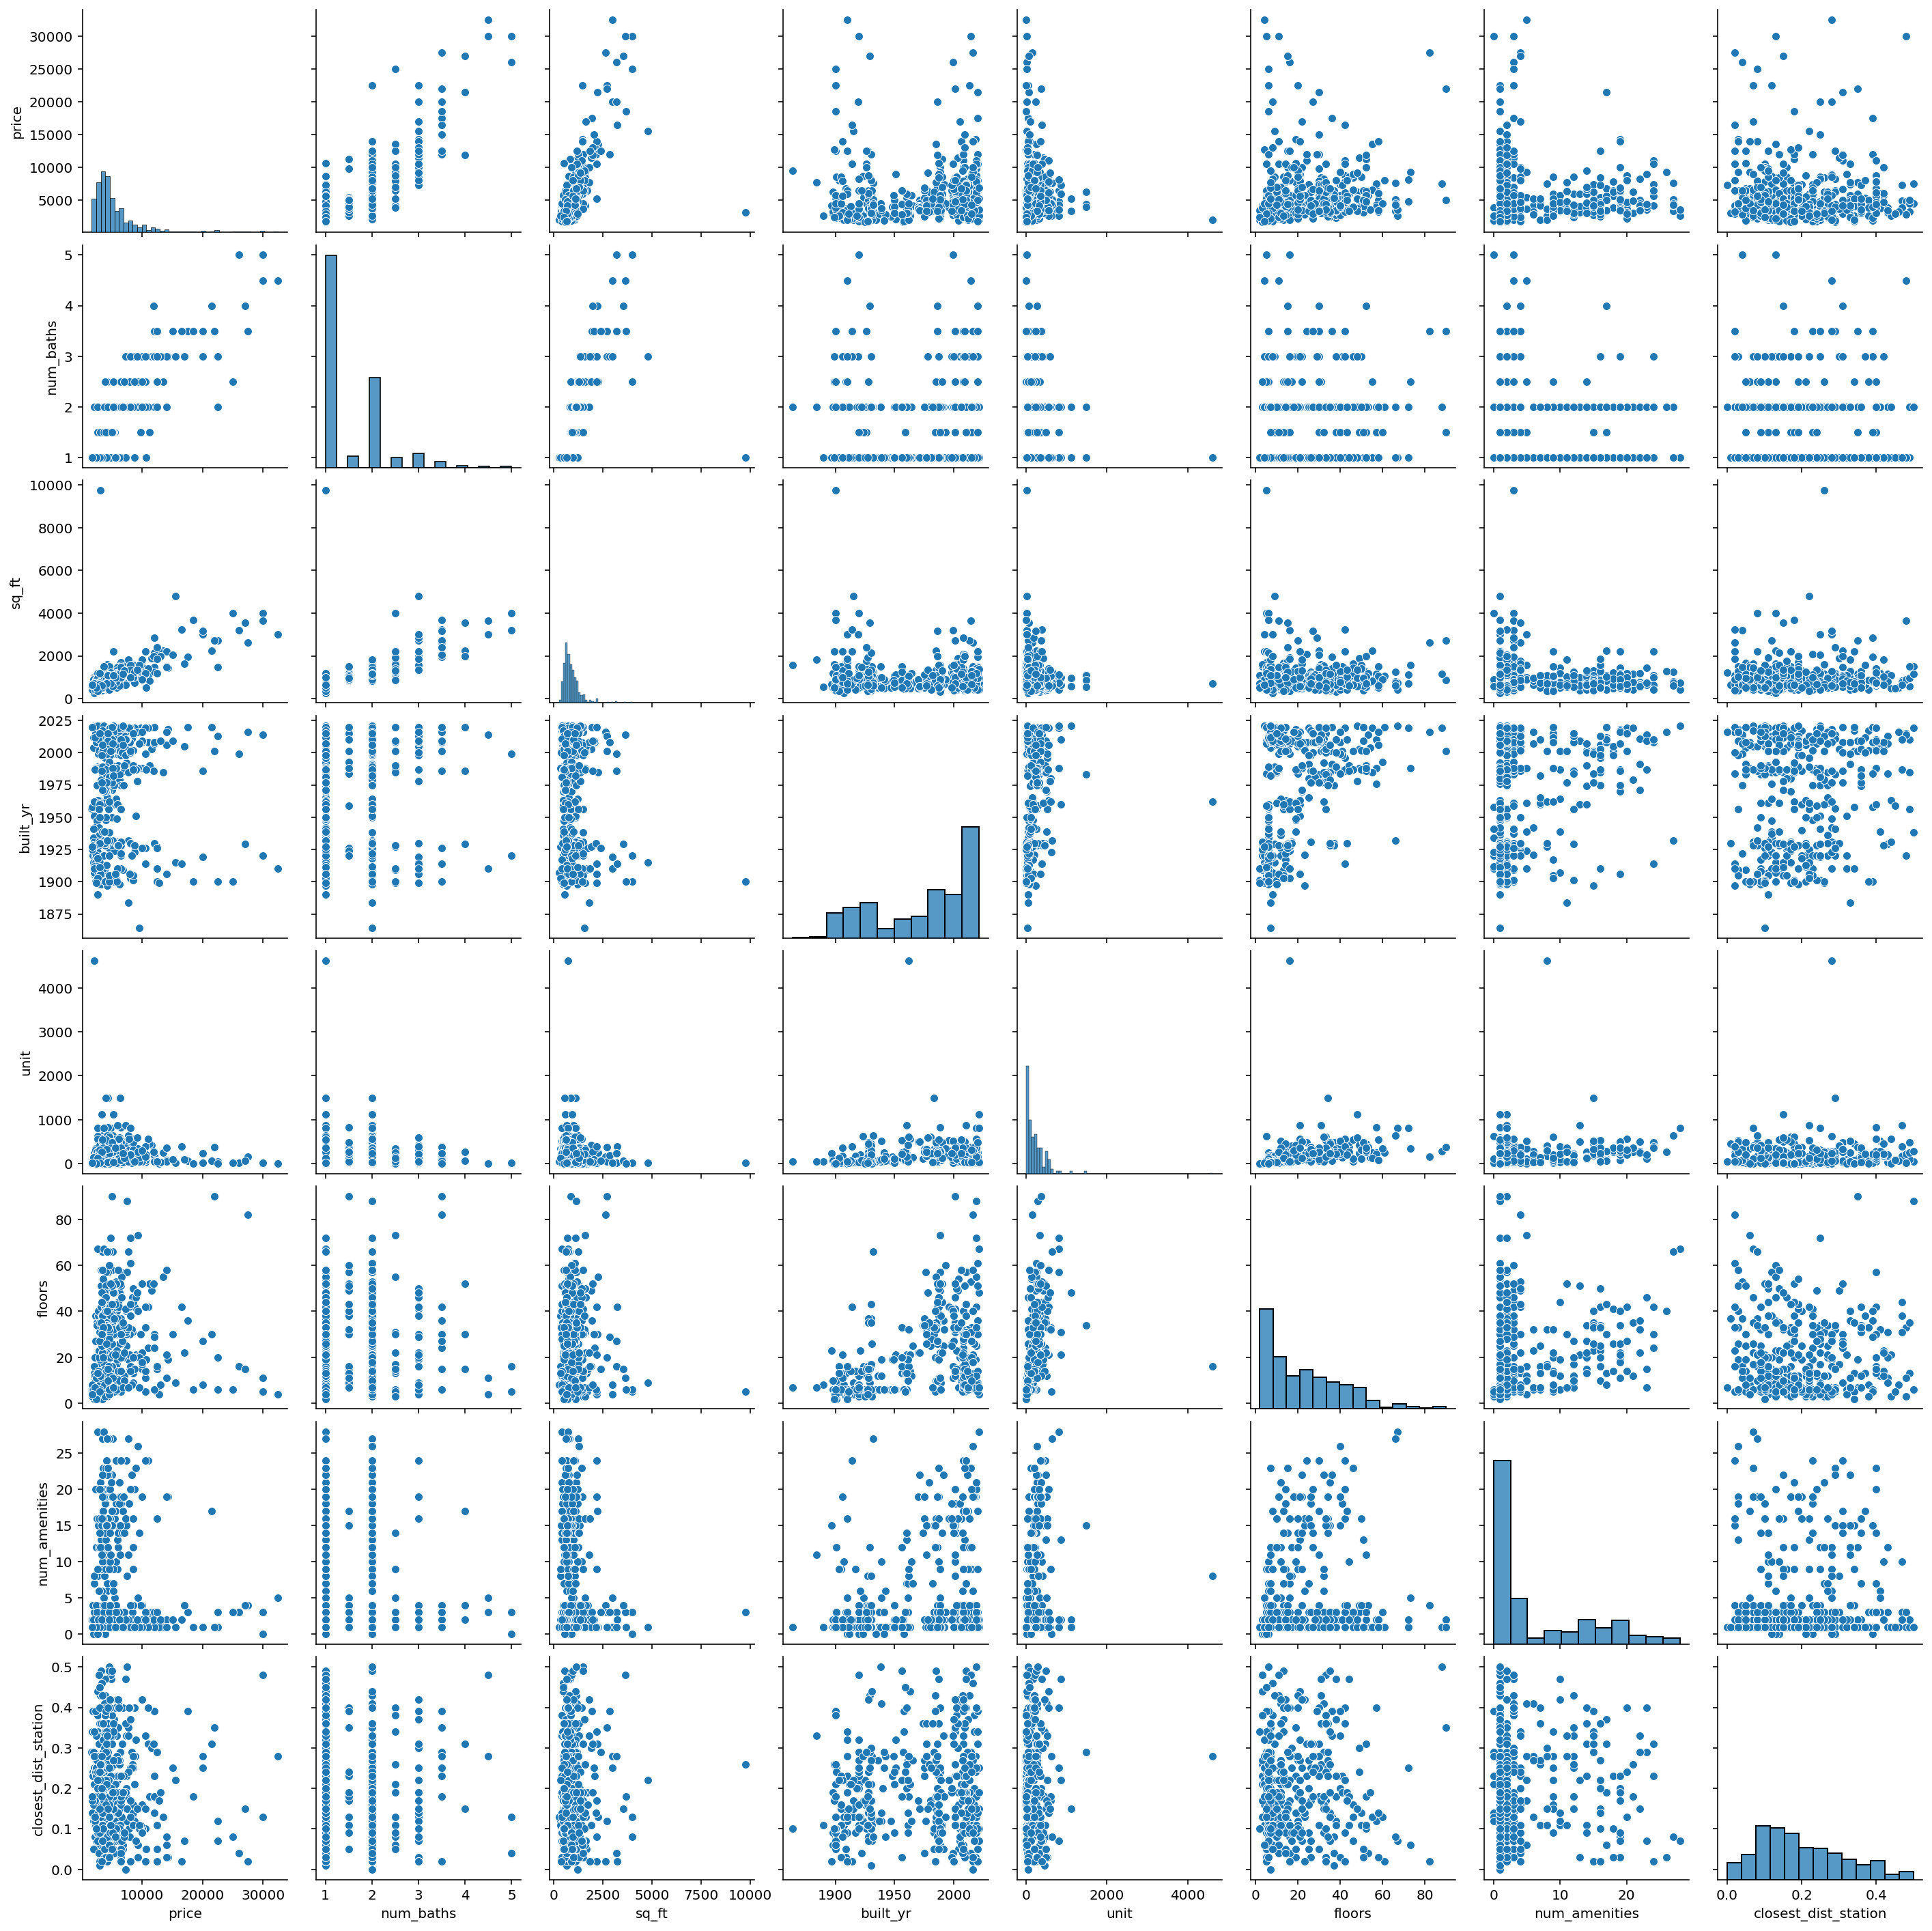

In [7]:
sns.pairplot(df)

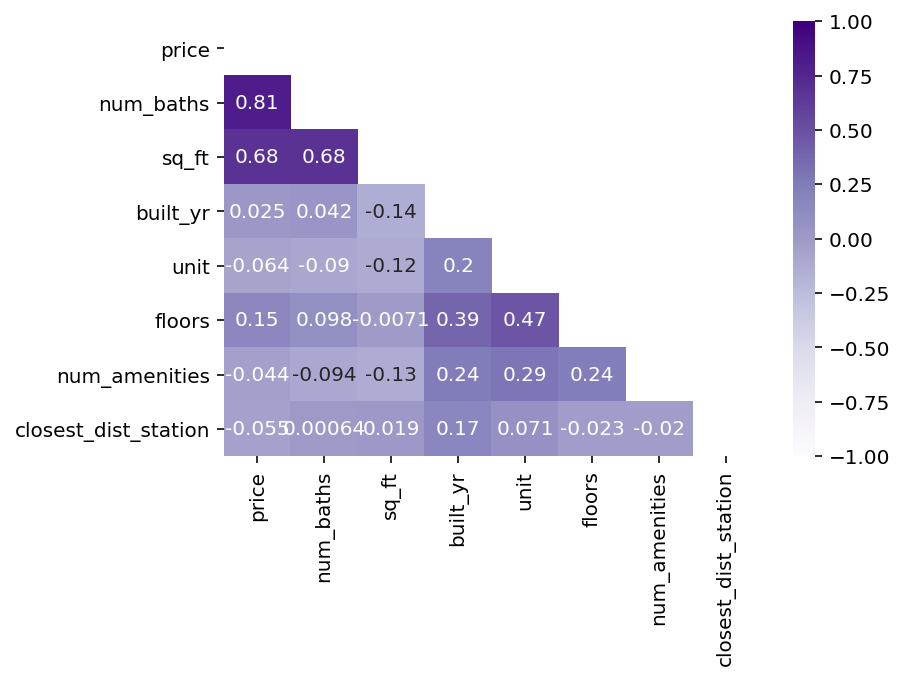

In [8]:
upper = np.triu(df.corr()) 
sns.heatmap(df.corr(), cmap="Purples", annot=True, vmin=-1, vmax=1, mask=upper);

In [9]:
df.corr() 

,price,num_baths,sq_ft,built_yr,unit,floors,num_amenities,closest_dist_station
price,1.000000,0.808414,0.680709,0.024517,-0.064122,0.154022,-0.043798,-0.054679
num_baths,0.808414,1.000000,0.683780,0.041815,-0.090431,0.097572,-0.093959,0.000645
sq_ft,0.680709,0.683780,1.000000,-0.137593,-0.119664,-0.007102,-0.129167,0.018726
built_yr,0.024517,0.041815,-0.137593,1.000000,0.198998,0.388852,0.244523,0.169461
unit,-0.064122,-0.090431,-0.119664,0.198998,1.000000,0.474118,0.290381,0.070781
floors,0.154022,0.097572,-0.007102,0.388852,0.474118,1.000000,0.242113,-0.023231
num_amenities,-0.043798,-0.093959,-0.129167,0.244523,0.290381,0.242113,1.000000,-0.019935
closest_dist_station,-0.054679,0.000645,0.018726,0.169461,0.070781,-0.023231,-0.019935,1.000000


> Looking at the pairplot above, I learned that there are outliers in a couple of features (i.e., sq_ft and unit) and the target is highly right skewed.

In [10]:
# treating categorical variables
apt_data = pd.get_dummies(df, columns = ['num_beds','fee'], drop_first = True)

In [11]:
df['neighborhood'].nunique()

60

> the number of neighborhoods is 60, which brings too many dummy variables. Instead of neighborhoods, I divided those into 4 boroughs.

In [12]:
manhattan = ['Greenwich Village', 'Chelsea','Washington Heights', 'Turtle Bay/United Nations', 'Broadway Corridor', 'Gramercy Park', 'Murray Hill',
          'Riverside Dr./West End Ave.', 'Lenox Hill' 'Tribeca', 'Midtown West','Midtown East', 'Hamilton Heights', 'Financial District',
          'Yorkville', 'Lower East Side', 'Battery Park City','Flatiron/Union Square', 'Central Park West','Harlem','SoHo','Beekman/Sutton Place',
          'Inwood''West Village','East Harlem', 'East Village','Morningside Heights', 'Lincoln Center''Park/Fifth Ave. to 79th St.', 'NoLiTa/Little Italy']

brooklyn = ['Bushwick','Flatbush','Clinton Hill','Gowanus', 'Williamsburg','Bedford-Stuyvesant','DUMBO','Downtown Brooklyn', 'Brooklyn Heights', 'Greenpoint',
 'Park Slope', 'South Slope - Greenwood Heights', 'Sheepshead Bay','Midwood', 'Gravesend','Crown Heights''Boerum Hill', 'Kensington',
       'Ditmars/Steinway','Highbridge','Cobble Hill', 'Fort Hamilton']

queens = ['Forest Hills','Long Island City','Rego Park','Ozone Park/S. Ozone Park','Sunnyside','Corona','Astoria/LIC']

bronx = ['Harlem']

In [13]:
apt_data['manhattan'] = apt_data['neighborhood'].apply(lambda x: 1 if x in manhattan else 0)
apt_data['brooklyn'] = apt_data['neighborhood'].apply(lambda x: 1 if x in brooklyn else 0)
apt_data['queens'] = apt_data['neighborhood'].apply(lambda x: 1 if x in queens else 0)
apt_data['bronx'] = apt_data['neighborhood'].apply(lambda x: 1 if x in bronx else 0)

### Defining targets and features 

In [14]:
y = apt_data['price']
X = apt_data.drop(columns = ['address','url','listed_date','price','neighborhood'])

X = sm.add_constant(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   const                 522 non-null    float64
 1   num_baths             522 non-null    float64
 2   sq_ft                 522 non-null    float64
 3   built_yr              522 non-null    float64
 4   unit                  522 non-null    float64
 5   floors                522 non-null    float64
 6   num_amenities         522 non-null    float64
 7   closest_dist_station  522 non-null    float64
 8   num_beds_2            522 non-null    uint8  
 9   num_beds_3            522 non-null    uint8  
 10  num_beds_4            522 non-null    uint8  
 11  num_beds_5            522 non-null    uint8  
 12  num_beds_Studio       522 non-null    uint8  
 13  fee_Condo             522 non-null    uint8  
 14  fee_Condop            522 non-null    uint8  
 15  fee_No Fee Rental     5

In [15]:
# Split into train, val, and test
# Hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=42)

lr = LinearRegression()
lr.fit(X_train,y_train)

print('Baseline OLS')
print('Train: ', lr.score(X_train,y_train).round(3))
print('Val: ', lr.score(X_val,y_val).round(3))

Baseline OLS
Train:  0.829
Val:  0.65


### Diagnostic Plotting

In [16]:
model = sm.OLS(y, X)
apt_model = model.fit()
apt_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     72.93
Date:                Wed, 15 Sep 2021   Prob (F-statistic):          3.22e-119
Time:                        01:02:39   Log-Likelihood:                -3713.8
No. Observations:                 417   AIC:                             7470.
Df Residuals:                     396   BIC:                             7554.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -2.373e+04   5676.036     -4.180      0.000   -3.49e+04   -1.26e+04
num_baths             1475.3529    325.315      4.535      0.000     835.793    2114.913
sq_ft                    4.8384      0.352     13.742      0.000       4.146       5.531
built_yr                11.7809      2.968      3.969      0.000       5.946      17.616
unit                    -0.1877      0.334     -0.562      0.575      -0.845       0.469
floors                  11.5316      6.922      1.666      0.097      -2.077      25.140
num_amenities            5.1813     14.688      0.353      0.724     -23.696      34.058
closest_dist_station -2503.4235    837.252     -2.990      0.003   -4149.437    -857.410
num_beds_2            -937.5207    301.879     -3.106      0.002   -1531.007    -344.034
num_beds_3            -468.6233    493.641     -0.949      0.343   -1439.109     501.862
num_beds_4           -3839.6088    939.416     -4.087      0.000   -5686.474   -1992.743
num_beds_5            4095.0898   1597.608      2.563      0.011     954.237    7235.943
num_beds_Studio         75.1277    286.635      0.262      0.793    -488.388     638.643
fee_Condo              110.5605    413.018      0.268      0.789    -701.421     922.542
fee_Condop             267.4458   1173.293      0.228      0.820   -2039.216    2574.108
fee_No Fee Rental      101.9912    402.980      0.253      0.800    -690.256     894.239
fee_Rental             479.9375    569.020      0.843      0.399    -638.740    1598.615
manhattan              -54.1903    324.873     -0.167      0.868    -692.882     584.501
brooklyn             -1235.2374    389.132     -3.174      0.002   -2000.261    -470.214
queens               -1544.6330    465.822     -3.316      0.001   -2460.426    -628.840
bronx                -2446.9726    614.629     -3.981      0.000   -3655.317   -1238.628
==============================================================================
Omnibus:                      232.488   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3453.522
Skew:                           2.035   Prob(JB):                         0.00
Kurtosis:                      16.498   Cond. No.                     1.40e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
def diagnostic_plots(y_pred, y_true, resid):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();

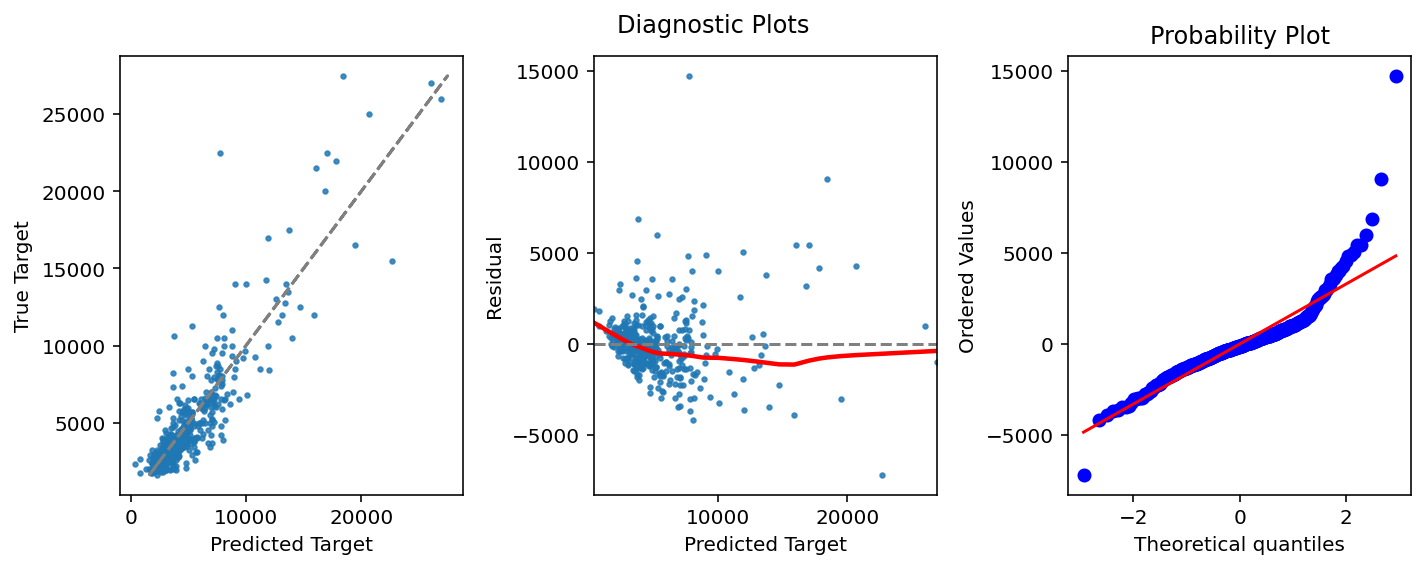

In [18]:
diagnostic_plots(apt_model.fittedvalues, y, apt_model.resid)

In [19]:
apt_data['predict'] = apt_model.predict(X)
apt_data['resid'] = y - apt_data.predict
resid = apt_data[apt_data['resid'] > 6000]
resid.sort_values(by = 'resid', ascending = False)

,address,price,num_baths,sq_ft,listed_date,neighborhood,built_yr,unit,floors,num_amenities,...,fee_Condo,fee_Condop,fee_No Fee Rental,fee_Rental,manhattan,brooklyn,queens,bronx,predict,resid
421,93 Crosby Street,22500.0,2.0,1473.0,Aug 13 2021,SoHo,1900.0,5.0,6.0,1.0,...,1,0,0,0,1,0,0,0,7751.699463,14748.300537
17,The Four Seasons Private Residences,27500.0,3.5,2631.0,Sep 1 2021,Tribeca,2016.0,157.0,82.0,4.0,...,1,0,0,0,0,0,0,0,18445.808192,9054.191808
495,The Chelsea,10620.0,1.0,517.0,Aug 10 2021,Chelsea,1987.0,204.0,19.0,2.0,...,0,0,1,0,1,0,0,0,3772.566302,6847.433698


In [20]:
resid2 = apt_data[apt_data['resid'] < -5000]
resid2.sort_values(by = 'resid', ascending = True)

,address,price,num_baths,sq_ft,listed_date,neighborhood,built_yr,unit,floors,num_amenities,...,fee_Condo,fee_Condop,fee_No Fee Rental,fee_Rental,manhattan,brooklyn,queens,bronx,predict,resid
304,93 Leonard Street,15500.0,3.0,4800.0,Aug 20 2021,Tribeca,1915.0,14.0,9.0,1.0,...,0,0,0,1,0,0,0,0,22679.864141,-7179.864141


In [21]:
print(apt_data.loc[17, 'url'])
print(apt_data.loc[421, 'url'])
print(apt_data.loc[304, 'url'])

https://www.cityrealty.com/nyc/tribeca/the-four-seasons-private-residences-30-park-place/apartment-64B/KzZMBfhqiof
https://www.cityrealty.com/nyc/soho/93-crosby-street/apartment-PH/iXdKpuUW
https://www.cityrealty.com/nyc/tribeca/93-leonard-street/apartment-3/GFRvWXtJzpD


In [22]:
apt_data = apt_data.drop(labels=[421,17,495,304], axis=0)

In [23]:
y = apt_data['price']
X = apt_data.drop(columns = ['address','price','listed_date','neighborhood','url','predict','resid'])

X = sm.add_constant(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 518 entries, 0 to 521
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   const                 518 non-null    float64
 1   num_baths             518 non-null    float64
 2   sq_ft                 518 non-null    float64
 3   built_yr              518 non-null    float64
 4   unit                  518 non-null    float64
 5   floors                518 non-null    float64
 6   num_amenities         518 non-null    float64
 7   closest_dist_station  518 non-null    float64
 8   num_beds_2            518 non-null    uint8  
 9   num_beds_3            518 non-null    uint8  
 10  num_beds_4            518 non-null    uint8  
 11  num_beds_5            518 non-null    uint8  
 12  num_beds_Studio       518 non-null    uint8  
 13  fee_Condo             518 non-null    uint8  
 14  fee_Condop            518 non-null    uint8  
 15  fee_No Fee Rental     5

In [24]:
model = sm.OLS(y, X)
apt_model = model.fit()
apt_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     83.77
Date:                Wed, 15 Sep 2021   Prob (F-statistic):          7.60e-145
Time:                        01:02:41   Log-Likelihood:                -4654.4
No. Observations:                 518   AIC:                             9351.
Df Residuals:                     497   BIC:                             9440.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.435e+04   5391.298     -2.662      0.008   -2.49e+04   -3761.540
num_baths             3599.3069    253.529     14.197      0.000    3101.186    4097.427
sq_ft                    1.2598      0.194      6.506      0.000       0.879       1.640
built_yr                 7.0326      2.825      2.489      0.013       1.482      12.584
unit                    -0.0916      0.350     -0.262      0.794      -0.779       0.596
floors                   9.9521      6.827      1.458      0.146      -3.461      23.365
num_amenities           21.2714     14.138      1.505      0.133      -6.506      49.049
closest_dist_station -1966.3975    795.921     -2.471      0.014   -3530.182    -402.613
num_beds_2           -1159.5770    277.920     -4.172      0.000   -1705.621    -613.533
num_beds_3            -368.2911    453.615     -0.812      0.417   -1259.531     522.949
num_beds_4            3336.4016    882.884      3.779      0.000    1601.756    5071.047
num_beds_5            5704.8636   1346.028      4.238      0.000    3060.257    8349.471
num_beds_Studio       -483.5679    265.122     -1.824      0.069   -1004.465      37.330
fee_Condo             -142.0504    407.127     -0.349      0.727    -941.953     657.852
fee_Condop            -268.0912   1085.774     -0.247      0.805   -2401.364    1865.182
fee_No Fee Rental     -264.8266    399.488     -0.663      0.508   -1049.720     520.067
fee_Rental             694.3815    562.365      1.235      0.218    -410.524    1799.287
manhattan              246.3706    320.054      0.770      0.442    -382.455     875.197
brooklyn              -873.7069    384.255     -2.274      0.023   -1628.672    -118.742
queens               -1036.3785    457.153     -2.267      0.024   -1934.570    -138.187
bronx                -1980.5479    625.005     -3.169      0.002   -3208.526    -752.570
==============================================================================
Omnibus:                      146.582   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1709.227
Skew:                           0.875   Prob(JB):                         0.00
Kurtosis:                      11.725   Cond. No.                     1.39e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

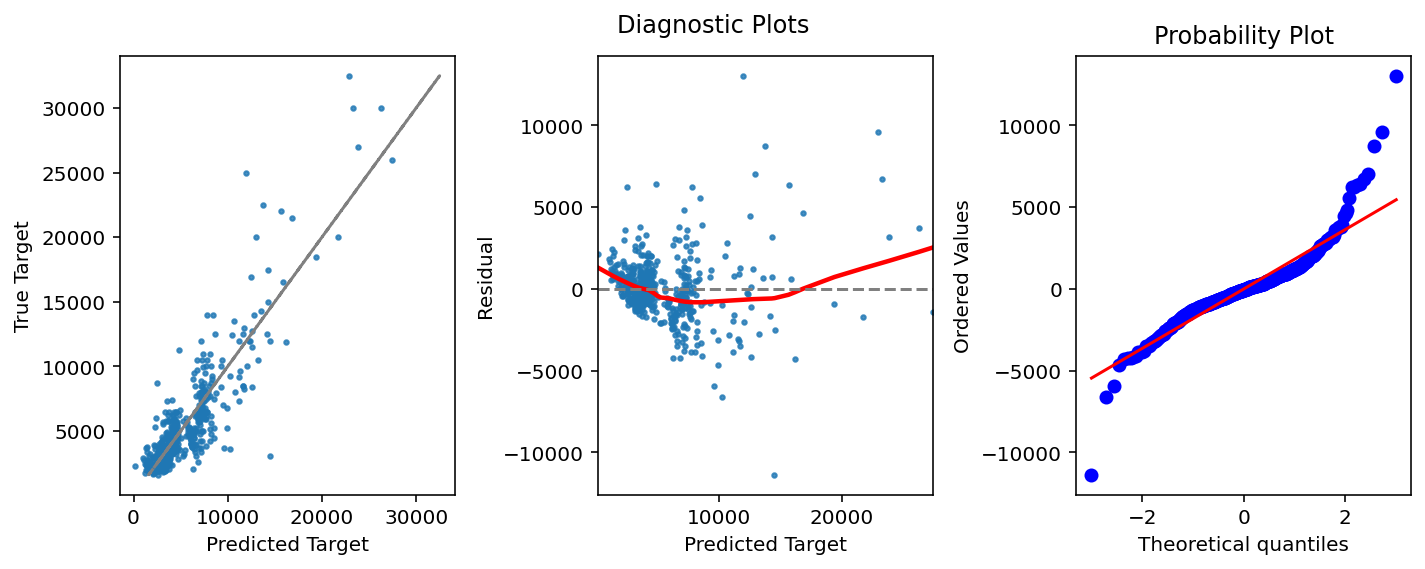

In [25]:
diagnostic_plots(apt_model.fittedvalues, y, apt_model.resid)

In [26]:
apt_data['predict'] = apt_model.predict(X)
apt_data['resid'] = y - apt_data.predict
resid = apt_data[apt_data['resid'] > 4000]
resid.sort_values(by = 'resid', ascending = False)
resid[['price','resid']]

,price,resid
70,8690.0,6206.949629
71,11260.0,6408.944788
150,25000.0,13044.446950
171,22500.0,8731.725091
215,12000.0,4812.984580
287,16950.0,4453.491445
291,30000.0,6737.111887
300,21500.0,4649.370726
316,32500.0,9572.904054
350,14000.0,5578.620458


In [27]:
apt_data = apt_data.drop(labels=[150,316,171,374,291,71,450,422,70,350,215,300,287], axis=0)

In [28]:
resid2 = apt_data[apt_data['resid'] < -5000]
resid2.sort_values(by = 'resid', ascending = True)

,address,price,num_baths,sq_ft,listed_date,neighborhood,built_yr,unit,floors,num_amenities,...,fee_Condo,fee_Condop,fee_No Fee Rental,fee_Rental,manhattan,brooklyn,queens,bronx,predict,resid
153,426 East 9th Street,3100.0,1.0,9745.0,Aug 25 2021,East Village,1900.0,20.0,5.0,3.0,...,0,0,1,0,1,0,0,0,14466.077948,-11366.077948
3,336 Starr Street,3600.0,2.0,1500.0,Sep 1 2021,Bushwick,1931.0,6.0,3.0,1.0,...,0,0,1,0,0,1,0,0,10228.416445,-6628.416445
389,519 West 143rd Street,3667.0,1.5,1500.0,Aug 14 2021,Hamilton Heights,1920.0,24.0,7.0,3.0,...,0,0,1,0,1,0,0,0,9630.840588,-5963.840588


In [29]:
apt_data = apt_data.drop(labels=[153,3,389], axis=0)

In [30]:
y = apt_data['price']
X = apt_data.drop(columns = ['address','price','listed_date','neighborhood','url','predict','resid'])

X = sm.add_constant(X)

model = sm.OLS(y, X)
apt_model = model.fit()
apt_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     127.8
Date:                Wed, 15 Sep 2021   Prob (F-statistic):          6.16e-178
Time:                        01:02:43   Log-Likelihood:                -4306.6
No. Observations:                 502   AIC:                             8655.
Df Residuals:                     481   BIC:                             8744.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -1.72e+04   3715.212     -4.631      0.000   -2.45e+04   -9903.289
num_baths             1636.8364    223.781      7.314      0.000    1197.127    2076.546
sq_ft                    3.6838      0.321     11.466      0.000       3.052       4.315
built_yr                 8.4632      1.939      4.364      0.000       4.652      12.274
unit                     0.0696      0.234      0.297      0.766      -0.391       0.530
floors                   7.0628      4.713      1.499      0.135      -2.197      16.323
num_amenities           24.7865      9.535      2.599      0.010       6.050      43.523
closest_dist_station -2041.3961    541.002     -3.773      0.000   -3104.415    -978.377
num_beds_2            -773.8732    192.831     -4.013      0.000   -1152.768    -394.978
num_beds_3            -671.1097    317.926     -2.111      0.035   -1295.805     -46.414
num_beds_4            2039.9940    807.044      2.528      0.012     454.227    3625.761
num_beds_5            5600.3711    971.645      5.764      0.000    3691.179    7509.563
num_beds_Studio       -145.0967    185.317     -0.783      0.434    -509.228     219.035
fee_Condo              141.0301    276.609      0.510      0.610    -402.481     684.541
fee_Condop            -167.6278    725.091     -0.231      0.817   -1592.365    1257.109
fee_No Fee Rental       84.9315    270.103      0.314      0.753    -445.797     615.660
fee_Rental             973.7658    381.887      2.550      0.011     223.394    1724.138
manhattan              319.0618    221.346      1.441      0.150    -115.862     753.986
brooklyn              -618.8970    262.739     -2.356      0.019   -1135.155    -102.639
queens               -1051.5321    311.550     -3.375      0.001   -1663.698    -439.366
bronx                -1861.8688    417.185     -4.463      0.000   -2681.600   -1042.138
==============================================================================
Omnibus:                       50.321   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.367
Skew:                           0.491   Prob(JB):                     6.64e-30
Kurtosis:                       5.336   Cond. No.                     1.40e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

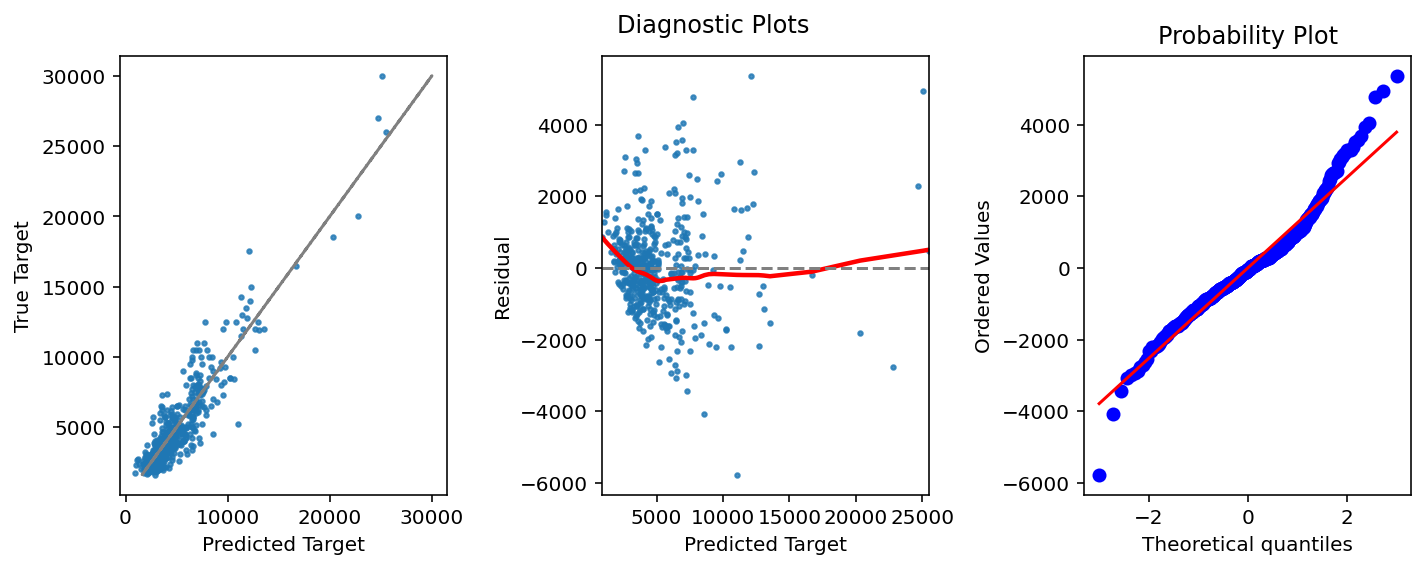

In [31]:
diagnostic_plots(apt_model.fittedvalues, y, apt_model.resid)

In [32]:
apt_data['predict'] = apt_model.predict(X)
apt_data['resid'] = y - apt_data.predict
resid = apt_data[apt_data['resid'] > 4000]
resid.sort_values(by = 'resid', ascending = False)
resid[['price','resid']]

,price,resid
2,11000.0,4032.340921
79,30000.0,4931.633691
113,17500.0,5362.656106
313,12500.0,4755.776154


In [33]:
resid2 = apt_data[apt_data['resid'] < -4000]
resid2.sort_values(by = 'resid', ascending = True)

,address,price,num_baths,sq_ft,listed_date,neighborhood,built_yr,unit,floors,num_amenities,...,fee_Condo,fee_Condop,fee_No Fee Rental,fee_Rental,manhattan,brooklyn,queens,bronx,predict,resid
346,906 Prospect Place,5250.0,2.5,2200.0,Aug 17 2021,Crown Heights,2020.0,19.0,5.0,9.0,...,1,0,0,0,0,0,0,0,11021.521537,-5771.521537
281,The York,4495.0,2.0,1500.0,Aug 20 2021,Yorkville,1956.0,244.0,13.0,1.0,...,0,0,0,1,1,0,0,0,8576.162241,-4081.162241


In [34]:
apt_data = apt_data.drop(labels=[2,79,113,313,346,281], axis=0)

In [35]:
y = apt_data['price']
X = apt_data.drop(columns = ['address','price','listed_date','neighborhood','url','predict','resid'])

X = sm.add_constant(X)

model = sm.OLS(y, X)
apt_model = model.fit()
apt_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     130.7
Date:                Wed, 15 Sep 2021   Prob (F-statistic):          1.29e-178
Time:                        01:02:44   Log-Likelihood:                -4205.6
No. Observations:                 496   AIC:                             8453.
Df Residuals:                     475   BIC:                             8542.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.761e+04   3391.079     -5.194      0.000   -2.43e+04   -1.09e+04
num_baths             1272.1662    206.607      6.157      0.000     866.190    1678.143
sq_ft                    3.8716      0.304     12.749      0.000       3.275       4.468
built_yr                 8.8770      1.768      5.021      0.000       5.403      12.351
unit                     0.0993      0.213      0.467      0.641      -0.318       0.517
floors                   6.4103      4.301      1.491      0.137      -2.041      14.861
num_amenities           25.7372      8.753      2.940      0.003       8.537      42.937
closest_dist_station -1893.3939    495.636     -3.820      0.000   -2867.305    -919.483
num_beds_2            -529.4386    180.518     -2.933      0.004    -884.152    -174.725
num_beds_3            -496.3570    298.255     -1.664      0.097   -1082.420      89.705
num_beds_4             744.6537    773.506      0.963      0.336    -775.263    2264.570
num_beds_5            6169.4378    908.838      6.788      0.000    4383.597    7955.278
num_beds_Studio        -96.7558    168.917     -0.573      0.567    -428.674     235.162
fee_Condo              203.5052    251.110      0.810      0.418    -289.920     696.930
fee_Condop            -266.1690    656.793     -0.405      0.685   -1556.747    1024.409
fee_No Fee Rental       79.8424    244.759      0.326      0.744    -401.102     560.787
fee_Rental             821.8165    358.211      2.294      0.022     117.942    1525.691
manhattan               84.1415    202.857      0.415      0.678    -314.467     482.750
brooklyn              -844.1117    239.972     -3.518      0.000   -1315.650    -372.573
queens               -1327.7558    284.619     -4.665      0.000   -1887.023    -768.489
bronx                -1839.0155    377.788     -4.868      0.000   -2581.358   -1096.673
==============================================================================
Omnibus:                       32.946   Durbin-Watson:                   1.781
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.987
Skew:                           0.530   Prob(JB):                     1.70e-10
Kurtosis:                       4.025   Cond. No.                     1.39e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

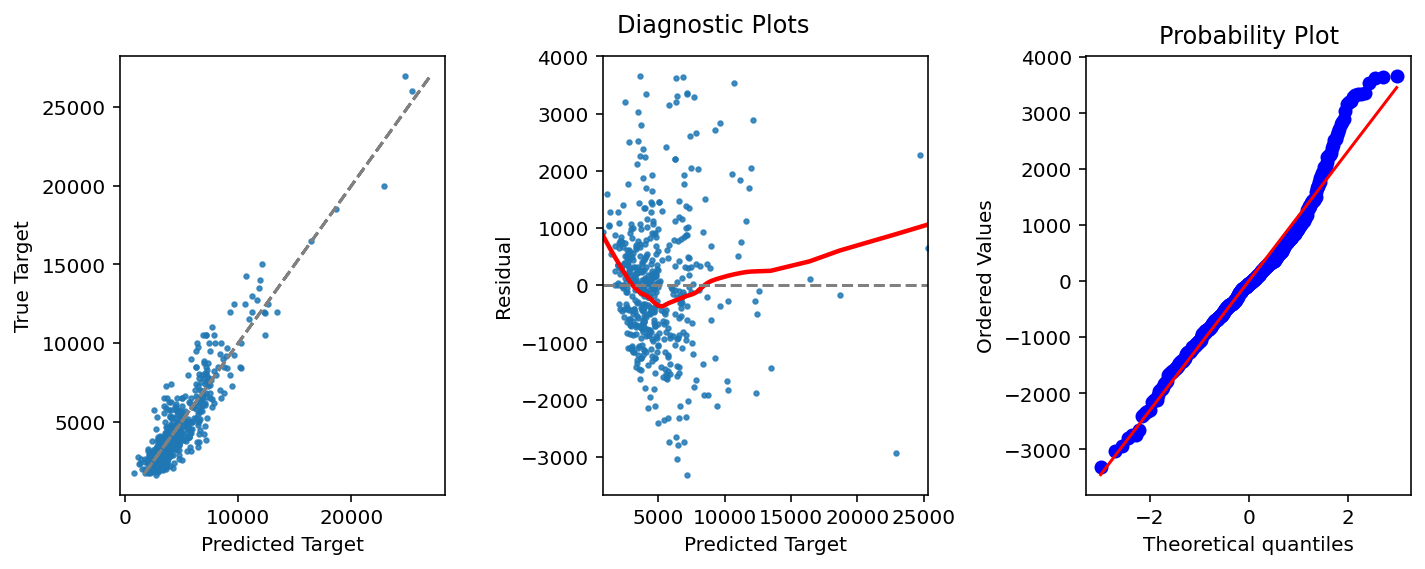

In [36]:
diagnostic_plots(apt_model.fittedvalues, y, apt_model.resid)

In [37]:
apt_data = apt_data[apt_data['price'] <15000]

In [38]:
y = apt_data['price']
X = apt_data.drop(columns = ['address','price','listed_date','neighborhood','url','predict','resid'])

X = sm.add_constant(X)

model = sm.OLS(y, X)
apt_model = model.fit()

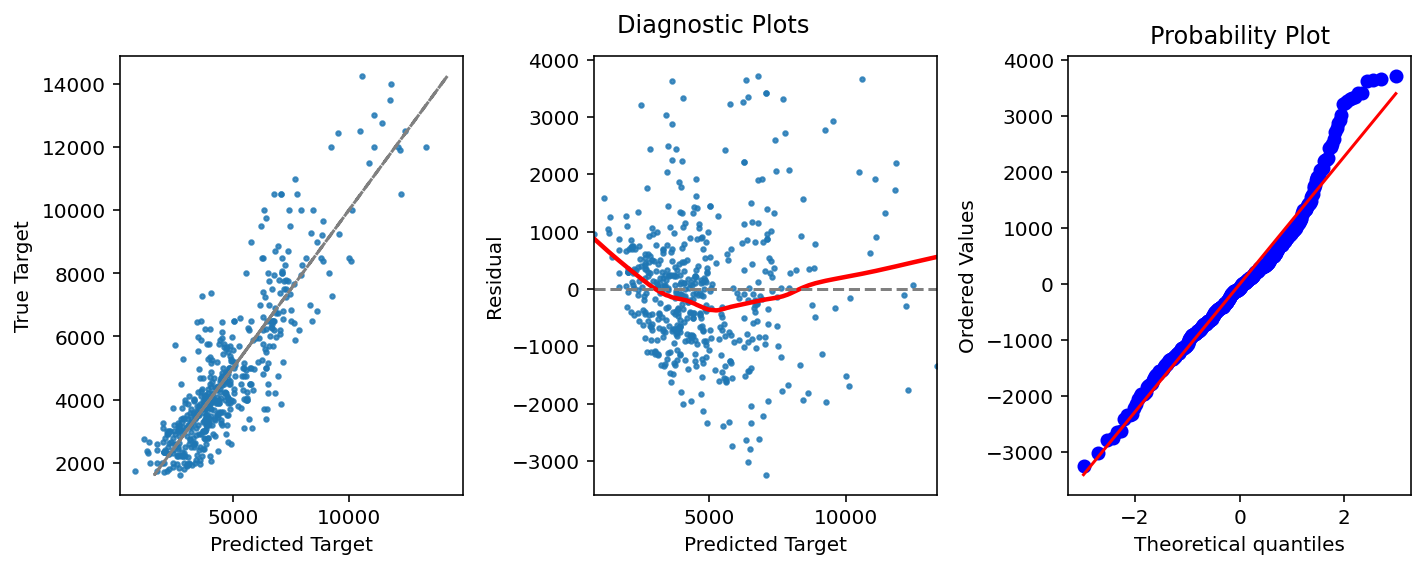

In [39]:
diagnostic_plots(apt_model.fittedvalues, y, apt_model.resid)

After removing suspicious outliers, I only considered the target prices less than $15000.

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif(X):
    '''
    Calculate the VIF for each feature of df (a Pandas DataFrame).
    '''
    vif_data = [variance_inflation_factor(X.values, i)
                for i in range(X.shape[1])]
    
    return pd.Series(vif_data, index=X.columns)
print('VIF')
vif = vif(X)
vif


VIF


/Users/hyewonjeong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


const                   4006.236421
num_baths                  5.425281
sq_ft                      5.202919
built_yr                   1.732190
unit                       1.463785
floors                     1.893634
num_amenities              1.537661
closest_dist_station       1.092434
num_beds_2                 2.538497
num_beds_3                 2.389611
num_beds_4                 1.086004
num_beds_5                      NaN
num_beds_Studio            1.423920
fee_Condo                  5.388755
fee_Condop                 1.209798
fee_No Fee Rental          5.136596
fee_Rental                 1.578826
manhattan                  3.213414
brooklyn                   2.729647
queens                     2.182282
bronx                      1.084538
dtype: float64

The VIF looks all good, so It seems not to have considerable multicolinearity. 

In [41]:
y = apt_data['price']

# drop insignificant features
X = apt_data[['num_baths','sq_ft','built_yr','num_amenities','closest_dist_station',
             'manhattan','brooklyn','queens','bronx']]
X = sm.add_constant(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490 entries, 0 to 521
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   const                 490 non-null    float64
 1   num_baths             490 non-null    float64
 2   sq_ft                 490 non-null    float64
 3   built_yr              490 non-null    float64
 4   num_amenities         490 non-null    float64
 5   closest_dist_station  490 non-null    float64
 6   manhattan             490 non-null    int64  
 7   brooklyn              490 non-null    int64  
 8   queens                490 non-null    int64  
 9   bronx                 490 non-null    int64  
dtypes: float64(6), int64(4)
memory usage: 42.1 KB


In [42]:
model = sm.OLS(y, X)
apt_model = model.fit()
apt_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     163.4
Date:                Wed, 15 Sep 2021   Prob (F-statistic):          5.05e-140
Time:                        01:02:47   Log-Likelihood:                -4162.4
No. Observations:                 490   AIC:                             8345.
Df Residuals:                     480   BIC:                             8387.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -2.015e+04   2953.120     -6.823      0.000    -2.6e+04   -1.43e+04
num_baths              980.7153    179.738      5.456      0.000     627.545    1333.885
sq_ft                    3.8634      0.295     13.093      0.000       3.284       4.443
built_yr                10.4361      1.508      6.918      0.000       7.472      13.400
num_amenities           25.7982      7.415      3.479      0.001      11.229      40.368
closest_dist_station -2010.4707    491.371     -4.092      0.000   -2975.974   -1044.967
manhattan              126.7437    203.938      0.621      0.535    -273.978     527.465
brooklyn              -923.5163    236.557     -3.904      0.000   -1388.331    -458.701
queens               -1495.2651    274.124     -5.455      0.000   -2033.897    -956.634
bronx                -2042.4942    368.501     -5.543      0.000   -2766.568   -1318.420
==============================================================================
Omnibus:                       30.378   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.106
Skew:                           0.471   Prob(JB):                     1.60e-10
Kurtosis:                       4.150   Cond. No.                     1.19e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
# Split into train, val, and test
# Hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                       test_size=.25,     
                                       random_state=42)
lr = LinearRegression()
lr.fit(X_train,y_train)

print('OLS')
print('Train: ', lr.score(X_train,y_train).round(3))
print('Val: ', lr.score(X_val,y_val).round(3))

OLS
Train:  0.77
Val:  0.702


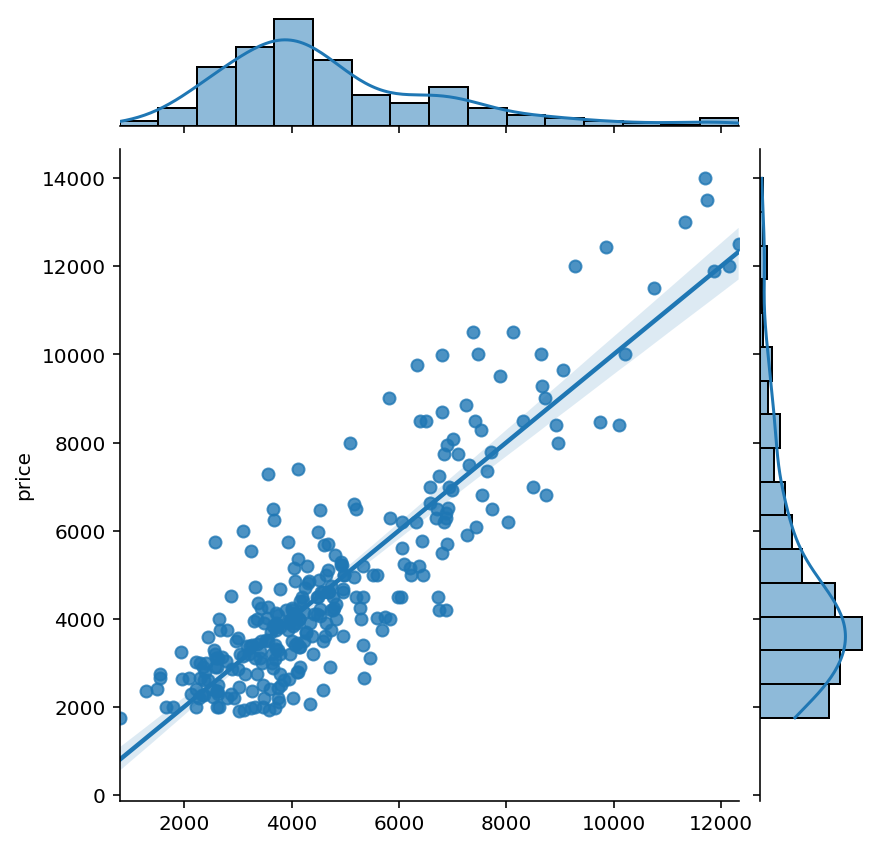

In [44]:
preds = lr.predict(X_train) # generate predictions (on training data) using fit model
sns.jointplot(x=preds,y=y_train, kind='reg');

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = mean_squared_error(y_train, preds, squared=False)
mae = mean_absolute_error(y_train, preds)
print('RMSE: ', rmse.round(3))
print('MAE: ', mae.round(3))

RMSE:  1151.743
MAE:  853.685


### log transformation 

In [47]:
y = apt_data['price']
y = np.log(y)

# drop insignificant features
X = apt_data[['num_baths','sq_ft','built_yr','num_amenities','closest_dist_station',
             'manhattan','brooklyn','queens','bronx']]

In [48]:
model = sm.OLS(y, sm.add_constant(X))
apt_model= model.fit()
apt_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     133.8
Date:                Wed, 15 Sep 2021   Prob (F-statistic):          8.66e-125
Time:                        01:02:50   Log-Likelihood:                -2.4586
No. Observations:                 490   AIC:                             24.92
Df Residuals:                     480   BIC:                             66.86
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.2511      0.607      3.708      0.000       1.058       3.444
num_baths                0.1560      0.037      4.223      0.000       0.083       0.229
sq_ft                    0.0007   6.07e-05     11.579      0.000       0.001       0.001
built_yr                 0.0027      0.000      8.771      0.000       0.002       0.003
num_amenities            0.0072      0.002      4.692      0.000       0.004       0.010
closest_dist_station    -0.3817      0.101     -3.779      0.000      -0.580      -0.183
manhattan                0.0141      0.042      0.336      0.737      -0.068       0.096
brooklyn                -0.2299      0.049     -4.727      0.000      -0.325      -0.134
queens                  -0.3790      0.056     -6.725      0.000      -0.490      -0.268
bronx                   -0.4038      0.076     -5.331      0.000      -0.553      -0.255
==============================================================================
Omnibus:                        4.960   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                5.482
Skew:                           0.136   Prob(JB):                       0.0645
Kurtosis:                       3.441   Cond. No.                     1.19e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
# Split into train, val, and test
# Hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                       test_size=.25,     
                                       random_state=42)

# Fit a simple linear regression on training set
lr = LinearRegression()
lr.fit(X_train,y_train)

print('OLS with a log transformation')
print('Train: ', lr.score(X_train,y_train).round(3))
print('Val: ', lr.score(X_val,y_val).round(3))
print('Test: ', lr.score(X_test, y_test).round(3))

OLS with a log transformation
Train:  0.723
Val:  0.702
Test:  0.702


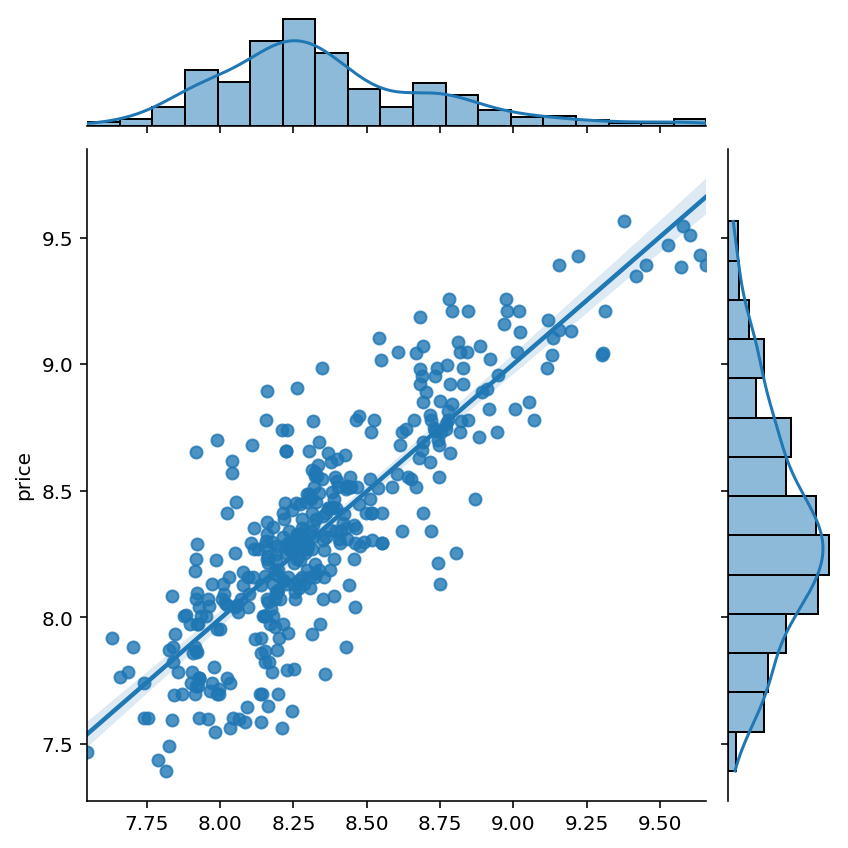

In [50]:
preds = lr.predict(X) # generate predictions (on training data) using fit model
sns.jointplot(x=preds,y=y, kind='reg');

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = mean_squared_error(y, preds, squared= False)
mae = mean_absolute_error(y, preds)
print('RMSE: ', rmse.round(3))
print('MAE: ', mae.round(3))

RMSE:  0.237
MAE:  0.181


## Regularization

Although there was not multicolinearity issue, we just want to check out how other stronger regression techniques would turn out.



In [52]:
from sklearn.linear_model import LinearRegression, Ridge 

In [53]:
# Linear Regression, Ridge, and Polynomial

lm = LinearRegression()

#Feature scaling 
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test for polynomial
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [54]:
# Validataion r^2 for the 3 models
lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.702
Ridge Regression val R^2: 0.702
Degree 2 polynomial regression val R^2: 0.276


In [65]:
lm = lm.fit(X,y)
lm_reg = lm_reg.fit(X,y)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')
print(f'Ridge Regression test R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression test R^2: 0.723
Ridge Regression test R^2: 0.723


In [66]:
lm_reg.coef_

array([ 0.15642021,  0.00070282,  0.00268092,  0.00726607, -0.3229069 ,
        0.02784623, -0.21209354, -0.35314994, -0.36816409])

Since we didn't have multicolinearity problem, K-Fold CV showed the same scores for Linear and Ridge regression.

In [56]:
from sklearn.model_selection import KFold

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #hold out 20% of the data for final testing
X, y = np.array(X), np.array(y)

In [57]:
kf = KFold(n_splits=5, shuffle=True, random_state = 70)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results from both models below

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val).round(3))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val).round(3))

print(f'Simple scores: \t{cv_lm_r2s}')
print(f'Ridge scores: \t{cv_lm_reg_r2s} \n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple scores: 	[0.511, 0.662, 0.692, 0.786, 0.738]
Ridge scores: 	[0.512, 0.662, 0.692, 0.787, 0.738] 

Simple mean cv r^2: 0.678 +- 0.093
Ridge mean cv r^2: 0.678 +- 0.093


In [63]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)

lm = lm.fit(X_scaled, y)
print(f'Simple Regression test R^2: {lm.score(X_test_scaled, y_test):.3f}')
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Simple Regression test R^2: 0.723
Ridge Regression test R^2: 0.723


### LassoCV

I selected Simple regression model as the best predictive model but Lasso has an advantage that it penalizes and drop insginificant coefficient. so I use this as to select the best interpret model 

In [60]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

## Scale the data as before
std = StandardScaler()
std.fit(X_train)

## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

# This is the best alpha value it found - not far from the value
# selected using simple validation
print(f'Lasso model alpha: {lasso_model.alpha_}')

# These are the (standardized) coefficients found
list(zip(X_train.columns, lasso_model.coef_))

# when it refit using that best alpha
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

# Find the MAE and R^2 on the test set using this model
mae = mean_absolute_error(y_test, test_set_pred)
r2 = r2_score(y_test, test_set_pred)

print(f'MAE: {mae.round(3)}')
print(f'r^2: {r2.round(3)}')

Lasso model alpha: 0.01
MAE: 0.178
r^2: 0.704


In [61]:
list(zip(X_train.columns, lasso_model.coef_))

[('num_baths', 0.08318297010404628),
 ('sq_ft', 0.25510454680913136),
 ('built_yr', 0.09618758769053452),
 ('num_amenities', 0.05273329005289905),
 ('closest_dist_station', -0.020047748859508874),
 ('manhattan', 0.0),
 ('brooklyn', -0.07277588430287492),
 ('queens', -0.09718799783933162),
 ('bronx', -0.05452434796527284)]